# Lab | Data cleaning and wrangling
For this lab, we will be using the same dataset we used in the previous labs. We recommend using the same notebook since you will be reusing the same variables you previous created and used in labs.

### Instructions
So far we have worked on EDA. This lab will focus on data cleaning and wrangling from everything we noticed before.

1. We will start with removing outliers. So far, we have discussed different methods to remove outliers. Use the one you feel more comfortable with, define a function for that. Use the function to remove the outliers and apply it to the dataframe.
2. Create a copy of the dataframe for the data wrangling.
3. Normalize the continuous variables. You can use any one method you want.
4. Encode the categorical variables
5. The time variable can be useful. Try to transform its data into a useful one. Hint: Day week and month as integers might be useful.
6. Since the model will only accept numerical data, check and make sure that every column is numerical, if some are not, change it using encoding.


In [209]:
import pandas as pd
import numpy as np
import datetime

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats

from sklearn.preprocessing import OneHotEncoder

# 1. Removing outliers. 

In [193]:
df = pd.read_csv('/Users/kt/Desktop/Ironhack/Data-Analytics-Ironhack/unit-4/lab-cleaning-numerical-data/we_fn_use_c_marketing_customer_value_analysis.csv')

# standardize column name following PE8
df.columns = [df.columns[i].lower().replace(' ', '_') for i in range(len(df.columns))] 
df.head()


,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,income,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer                       9134 non-null   object 
 1   state                          9134 non-null   object 
 2   customer_lifetime_value        9134 non-null   float64
 3   response                       9134 non-null   object 
 4   coverage                       9134 non-null   object 
 5   education                      9134 non-null   object 
 6   effective_to_date              9134 non-null   object 
 7   employmentstatus               9134 non-null   object 
 8   gender                         9134 non-null   object 
 9   income                         9134 non-null   int64  
 10  location_code                  9134 non-null   object 
 11  marital_status                 9134 non-null   object 
 12  monthly_premium_auto           9134 non-null   i

In [11]:
numerical = df.select_dtypes(include="number")
numerical.head()

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
0,2763.519279,56274,69,32,5,0,1,384.811147
1,6979.535903,0,94,13,42,0,8,1131.464935
2,12887.431650,48767,108,18,38,0,2,566.472247
3,7645.861827,0,106,18,65,0,7,529.881344
4,2813.692575,43836,73,12,44,0,1,138.130879


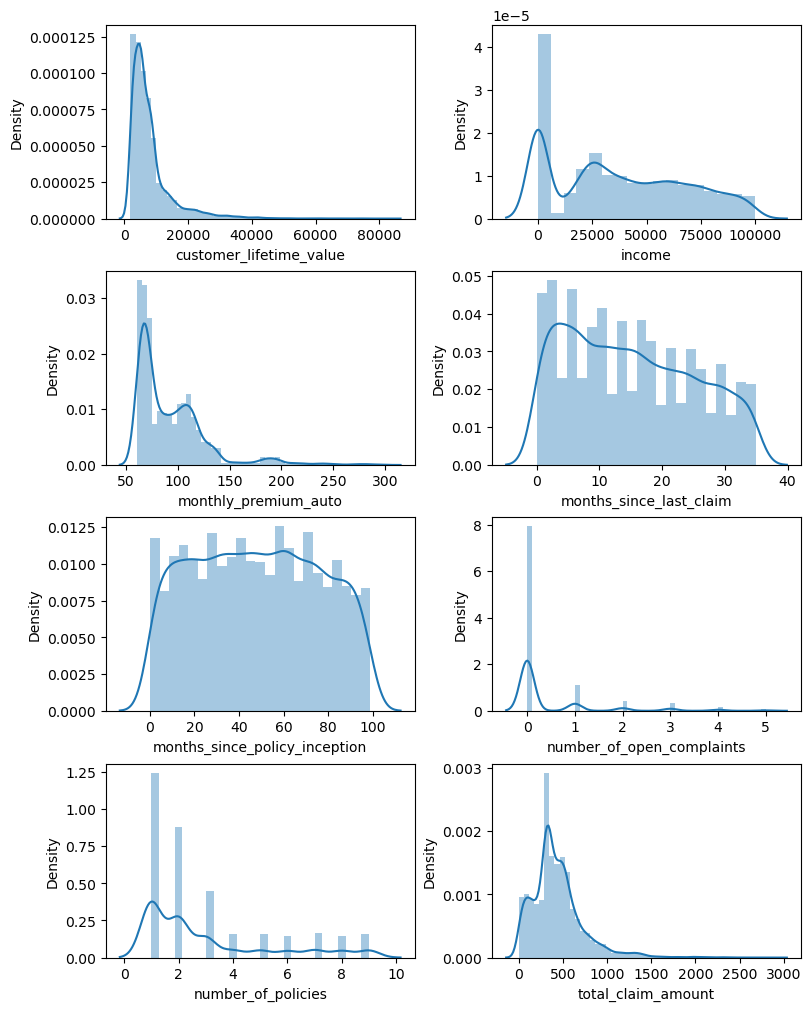

In [13]:
# quick check distribution 

fig = plt.figure(figsize = (8, 10), constrained_layout = True)

for i, column in enumerate(numerical.columns):
    fig.add_subplot(4, 2, i + 1) 
    sns.distplot(numerical[column])

The plots above show that three columns are continuous data: customer_lifetime_value, income, and total_claim_amount.
Elses are discrete data.


In [60]:
# To work on outliers, need continuous data

contin_df = numerical[['customer_lifetime_value', 'income', 'total_claim_amount']]
contin_df.head()

,customer_lifetime_value,income,total_claim_amount
0,2763.519279,56274,384.811147
1,6979.535903,0,1131.464935
2,12887.431650,48767,566.472247
3,7645.861827,0,529.881344
4,2813.692575,43836,138.130879


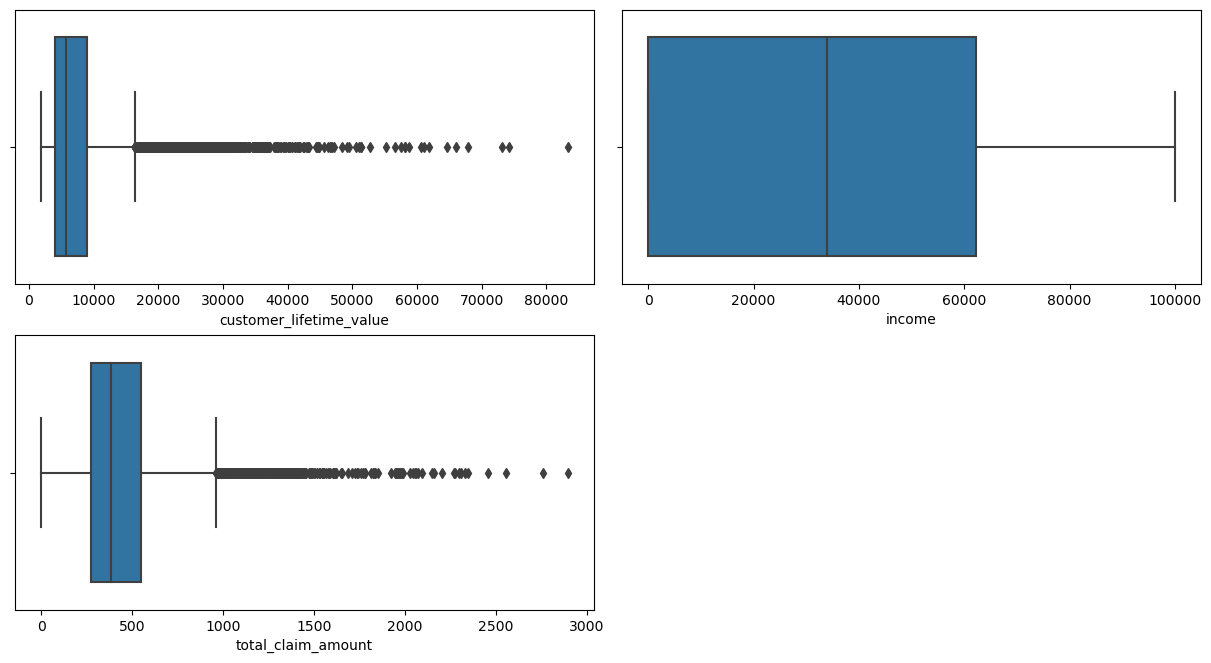

In [61]:
# quick check on boxplot before removing outliers (visualize outliers)

fig = plt.figure(figsize = (12, 12), constrained_layout = True)

for i, column in enumerate(contin_df.columns):
    fig.add_subplot(4, 2, i + 1) 
    sns.boxplot(contin_df[column])

### What did we get from boxplots above?

- Boxplots show that customer_lifetime_value and total_claim_amount have (a lot of) values that exceed the upper limit of a (mild) outlier (1.5 x IQR).
- But because there is too much information that will be lost if we move all those values. 

       - So first, I want to check how many information (rows) are there.
       - Then decide if that too much to remove or we might need to adjust the upper limit.

In [62]:
# calculate 1.5 x IQR, in order to see those values that are mild outliers

upper_limit = np.percentile(contin_df["customer_lifetime_value"],75) + 1.5*iqr
lower_limit = np.percentile(contin_df["customer_lifetime_value"],25) - 1.5*iqr

print('Upper limit (mild): ', upper_limit)
print('Lower limit (mild): ', lower_limit)

Upper limit (mild):  16414.039911750002
Lower limit (mild):  -3457.6210762500014


In [80]:
# how many values are (mild) outliers

mild_outliers = contin_df[(contin_df["customer_lifetime_value"] < lower_limit) | (contin_df["customer_lifetime_value"] > upper_limit)]

print('Number of (mild) outliers: ', len(mild_outliers), 'values')
print('Proportion to the whole dataset: ', round(len(mild_outliers)*100/len(contin_df), 2), '%')

Number of (mild) outliers:  817 values
Proportion to the whole dataset:  8.94 %


### My thought on this

- 9% of data to be lost. I think it's a lot. We could lose important information on that portion.
- So I prefer to set the upper limit where those outliers should be less than 1% of the dataset

In [81]:
# find new upper limit (extreme)
upper_limit_extreme = np.percentile(contin_df["customer_lifetime_value"],75) + 6*iqr
lower_limit_extreme = np.percentile(contin_df["customer_lifetime_value"],25) - 6*iqr
print('Upper limit (extreme): ', upper_limit_extreme)
print('Lower limit (extreme): ', lower_limit_extreme)



# filter the extreme outliers
extreme_outliers = contin_df[(contin_df["customer_lifetime_value"] < lower_limit_extreme) | (contin_df["customer_lifetime_value"] > upper_limit_extreme)]
print('Number of (extreme) outliers: ', len(extreme_outliers), 'values')
print('Proportion to the whole dataset: ', round(len(extreme_outliers)*100/len(contin_df), 2), '%')



Upper limit (mild):  38769.65852325001
Lower limit (mild):  -25813.239687750007
Number of (mild) outliers:  66 values
Proportion to the whole dataset:  0.72 %


- After setting the extreme upper limit (whis=6), outliers are 0.72% of the data. 
- To me, it is forgivable to remove those data. But let's check the plot again to see how those data look like.

<AxesSubplot:xlabel='customer_lifetime_value'>

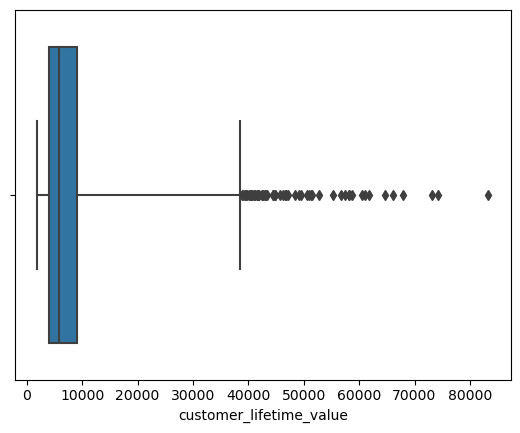

In [78]:
# check if we can remove those extreme outliers and be happy about it
sns.boxplot(contin_df["customer_lifetime_value"], whis=6)

- I don't feel comfortable removing those data and considering them outliers. Because to delete these outliers, it means removing the whole row of data.
- There are a bunch of data (could be about 50 values) that can be considered one group of (important) information
- At this point, I don't know exactly what is the right approach to deal with this
- My thought: 

        - I consider removing < 1% of data is not that much but I'd like to be safer to not remove too much (they could be important). 
        - So I decided to move the upper limit, to remove about < 0.5% (we can still remove them later in the process after well consideration.)

In [92]:
# set new upper limit (extreme)
upper_limit_extreme = np.percentile(contin_df["customer_lifetime_value"],75) + 7*iqr
lower_limit_extreme = np.percentile(contin_df["customer_lifetime_value"],25) - 7*iqr
print('Upper limit (extreme): ', upper_limit_extreme)
print('Lower limit (extreme): ', lower_limit_extreme)



# filter the extreme outliers
extreme_outliers = contin_df[(contin_df["customer_lifetime_value"] < lower_limit_extreme) | (contin_df["customer_lifetime_value"] > upper_limit_extreme)]
print('Number of (extreme) outliers: ', len(extreme_outliers), 'values')
print('Proportion to the whole dataset: ', round(len(extreme_outliers)*100/len(contin_df), 2), '%')



Upper limit (mild):  43737.57377025001
Lower limit (mild):  -30781.15493475001
Number of (mild) outliers:  34 values
Proportion to the whole dataset:  0.37 %


<AxesSubplot:xlabel='customer_lifetime_value'>

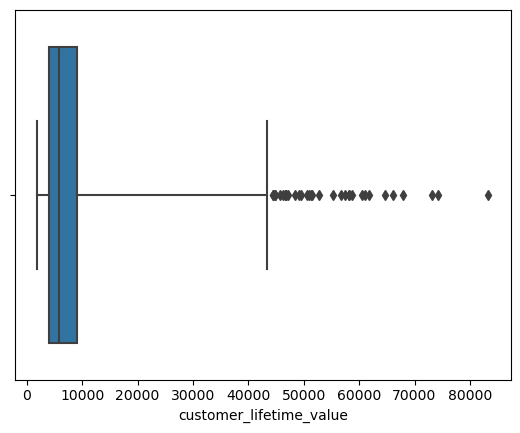

In [90]:
# check boxplot one more time
sns.boxplot(contin_df["customer_lifetime_value"], whis=7)

In [101]:
# remove extreme outliers from the data
contin_df = contin_df[(contin_df["customer_lifetime_value"] > lower_limit_extreme) & (contin_df["customer_lifetime_value"] < upper_limit_extreme)]

print('We now have', len(contin_df), 'rows in the data frame')



We now have 9100 rows in the data frame


### What I see here

- After removing 34 rows, this means we also removed those outliers in the total_claim_amount column as well.
- So I do boxplot again to do a quick check on continuous data

        - There are three values that look like outliers but consider total_claim_amount (see plot below) as a target of this dataset. So we don't need to delete those values.

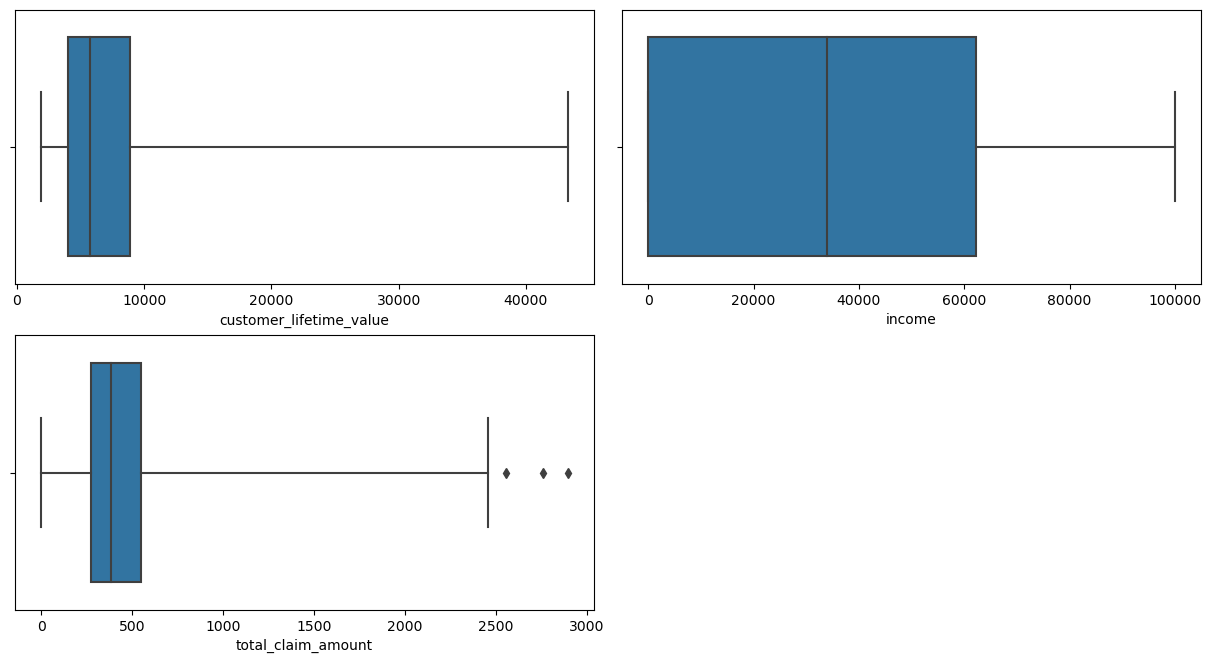

In [100]:
# quick check on boxplot before removing outliers (visualize outliers)

fig = plt.figure(figsize = (12, 12), constrained_layout = True)

for i, column in enumerate(contin_df.columns):
    fig.add_subplot(4, 2, i + 1) 
    sns.boxplot(contin_df[column], whis=7)

# 2. Create a copy of the dataframe for the data wrangling.


In [194]:
df_copy = df.copy()

In [195]:
len(df_copy)

9134

In [196]:
df_copy.head()

,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,income,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [197]:
df_copy = df_copy.drop(['customer'], axis=1)

# change effective_to_date to datetime
df_copy['effective_to_date'] = pd.to_datetime(df_copy['effective_to_date'])

In [198]:
# remove the outliers that we made example in previous step
upper_limit = np.percentile(df_copy["customer_lifetime_value"],75) + 7*iqr
lower_limit = np.percentile(df_copy["customer_lifetime_value"],25) - 7*iqr
print('Upper limit (extreme): ', upper_limit)
print('Lower limit (extreme): ', lower_limit)


# how many rows to delete
extreme_outliers = df_copy[(df_copy["customer_lifetime_value"] < lower_limit) | (df_copy["customer_lifetime_value"] > upper_limit)]
print('Number of (extreme) outliers: ', len(extreme_outliers), 'values')
print('Proportion to the whole dataset: ', round(len(extreme_outliers)*100/len(df_copy), 2), '%')

# remove extreme outliers from the data
df_copy = df_copy[(df_copy["customer_lifetime_value"] > lower_limit) & (df_copy["customer_lifetime_value"] < upper_limit)]
print('We now have', len(df_copy), 'rows in the data frame')


Upper limit (extreme):  43737.57377025001
Lower limit (extreme):  -30781.15493475001
Number of (extreme) outliers:  34 values
Proportion to the whole dataset:  0.37 %
We now have 9100 rows in the data frame


# 3. Normalize the continuous variables. 

You can use any one method you want.


In [199]:
# get numerical data
numerical = df_copy.select_dtypes(include="number")

# get continuous data for normalisation (exclude total_claim_amount because it is out target)
cont_df = numerical[['customer_lifetime_value', 'income', 'total_claim_amount']]
cont_df.head()

,customer_lifetime_value,income,total_claim_amount
0,2763.519279,56274,384.811147
1,6979.535903,0,1131.464935
2,12887.431650,48767,566.472247
3,7645.861827,0,529.881344
4,2813.692575,43836,138.130879


In [200]:
X = cont_df[['customer_lifetime_value', 'income']]
y = cont_df[['income']]

In [201]:
# I've never done Box-Cox transformation so I'll try Box-Cox this time

def boxcox_transform(df):
    continous_cols = df.columns
    _ci = {column: None for column in continous_cols}
    for column in continous_cols:
        df[column] = np.where(df[column]<=0, np.NAN, df[column]) # fill 0 with NaN
        df[column] = df[column].fillna(df[column].mean()) # fill NaN with mean
        transformed_data, ci = stats.boxcox(df[column]) # transform with Box-Cox
        df[column] = transformed_data
        _ci[column] = [ci] 
    return df, _ci
X_tranformed, _ci = boxcox_transform(X)

In [202]:
X_tranformed.head()

,customer_lifetime_value,income
0,2.856682,1237.091748
1,2.918620,1157.747047
2,2.950527,1134.271699
3,2.923773,1157.747047
4,2.858070,1063.303375


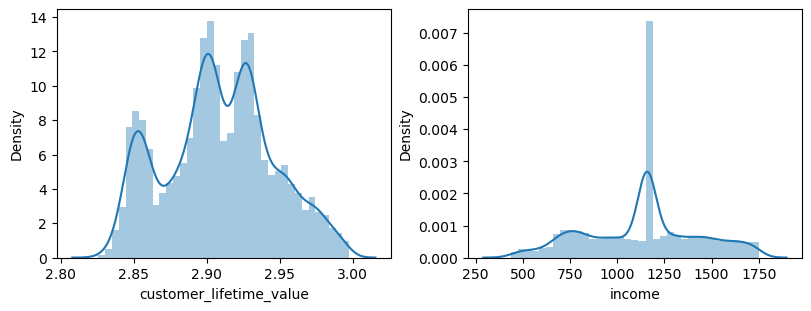

In [203]:
# check distribution after transformed data


fig = plt.figure(figsize = (8, 3), constrained_layout = True)

for i, column in enumerate(X_tranformed.columns):
    fig.add_subplot(1, 2, i + 1) 
    sns.distplot(X_tranformed[column])

# 4. Encode the categorical variables


In [204]:
categorical = df_copy.select_dtypes(include="object")
categorical.head()

,state,response,coverage,education,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,Washington,No,Basic,Bachelor,Employed,F,Suburban,Married,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize
1,Arizona,No,Extended,Bachelor,Unemployed,F,Suburban,Single,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize
2,Nevada,No,Premium,Bachelor,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize
3,California,No,Basic,Bachelor,Unemployed,M,Suburban,Married,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize
4,Washington,No,Basic,Bachelor,Employed,M,Rural,Single,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize


In [205]:
categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9100 entries, 0 to 9133
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   state             9100 non-null   object
 1   response          9100 non-null   object
 2   coverage          9100 non-null   object
 3   education         9100 non-null   object
 4   employmentstatus  9100 non-null   object
 5   gender            9100 non-null   object
 6   location_code     9100 non-null   object
 7   marital_status    9100 non-null   object
 8   policy_type       9100 non-null   object
 9   policy            9100 non-null   object
 10  renew_offer_type  9100 non-null   object
 11  sales_channel     9100 non-null   object
 12  vehicle_class     9100 non-null   object
 13  vehicle_size      9100 non-null   object
dtypes: object(14)
memory usage: 1.0+ MB


In [207]:
# check value_counts for each column before encoding them

for column in categorical.columns:
    print("\n" + column)
    print(categorical[column].value_counts())


state
California    3140
Oregon        2591
Arizona       1697
Nevada         878
Washington     794
Name: state, dtype: int64

response
No     7792
Yes    1308
Name: response, dtype: int64

coverage
Basic       5560
Extended    2725
Premium      815
Name: coverage, dtype: int64

education
Bachelor                2739
College                 2671
High School or Below    2610
Master                   739
Doctor                   341
Name: education, dtype: int64

employmentstatus
Employed         5673
Unemployed       2309
Medical Leave     432
Disabled          404
Retired           282
Name: employmentstatus, dtype: int64

gender
F    4642
M    4458
Name: gender, dtype: int64

location_code
Suburban    5758
Rural       1768
Urban       1574
Name: location_code, dtype: int64

marital_status
Married     5276
Single      2457
Divorced    1367
Name: marital_status, dtype: int64

policy_type
Personal Auto     6759
Corporate Auto    1964
Special Auto       377
Name: policy_type, dtype: int

In [208]:
# drop policy because of redundancy
categorical = categorical.drop(['policy'], axis=1)

In [211]:
categorical.shape

(9100, 13)

In [210]:
# Decoding categorical

encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
encoder.fit(categorical)
encoded = encoder.transform(categorical).toarray() # transform step = encoding step --> get an array as a result 
cat_encoded = pd.DataFrame(encoded) # put the array into a data frame
cat_encoded.columns = encoder.get_feature_names_out() # name the columns after transformation
cat_encoded.shape

(9100, 35)

In [212]:
# Concat categorical & numerical data (the normalized one) into one data frame, X
X = pd.concat([X_tranformed, cat_encoded], axis=1)
X.shape

(9134, 37)

# 5. The time variable can be useful. 

Try to transform its data into a useful one. 
Hint: Day week and month as integers might be useful.


In [223]:
# extract day, week, month and I put them into X dataframe directly in order to use
X['day'] = df_copy['effective_to_date'].dt.day
X['week'] = df_copy['effective_to_date'].dt.week
X['month'] = df_copy['effective_to_date'].dt.month

In [227]:
X.head(3)

,customer_lifetime_value,income,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,coverage_Extended,coverage_Premium,education_College,...,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small,day,week,month
0,2.856682,1237.091748,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,24.0,8.0,2.0
1,2.918620,1157.747047,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,31.0,5.0,1.0
2,2.950527,1134.271699,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,19.0,7.0,2.0


# 6. Since the model will only accept numerical data, check and make sure that every column is numerical, if some are not, change it using encoding.

In [226]:
# check data type of all columns >> they are all numerical

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9134 entries, 0 to 8825
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_lifetime_value         9100 non-null   float64
 1   income                          9100 non-null   float64
 2   state_California                9100 non-null   float64
 3   state_Nevada                    9100 non-null   float64
 4   state_Oregon                    9100 non-null   float64
 5   state_Washington                9100 non-null   float64
 6   response_Yes                    9100 non-null   float64
 7   coverage_Extended               9100 non-null   float64
 8   coverage_Premium                9100 non-null   float64
 9   education_College               9100 non-null   float64
 10  education_Doctor                9100 non-null   float64
 11  education_High School or Below  9100 non-null   float64
 12  education_Master                91

In [ ]:
#### LAB ENDED AND THANK YOU FOR CHECKING :) ####